In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, features, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.features = features
        self.depth = features // num_heads

        self.Wq = nn.Linear(features, features)
        self.Wk = nn.Linear(features, features)
        self.Wv = nn.Linear(features, features)

        self.fc = nn.Linear(features, features)

    def forward(self, x):
        batch_size, num_points, _ = x.shape

        query = self.Wq(x).view(batch_size, num_points, self.num_heads, self.depth).transpose(1, 2)
        key = self.Wk(x).view(batch_size, num_points, self.num_heads, self.depth).transpose(1, 2)
        value = self.Wv(x).view(batch_size, num_points, self.num_heads, self.depth).transpose(1, 2)

        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.depth ** 0.5)
        attention = F.softmax(scores, dim=-1)

        out = torch.matmul(attention, value).transpose(1, 2).contiguous()
        out = out.view(batch_size, num_points, self.features)
        
        return self.fc(out)

class MHA_AutoEncoder(nn.Module):
    def __init__(self, point_features, num_heads, latent_dim):
        super().__init__()
        self.encoder = MultiHeadAttention(point_features, num_heads)
        self.decoder = MultiHeadAttention(point_features, num_heads)
    
    def forward(self, x):
        batch_size, num_points, _ = x.shape
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded



In [2]:
import sys
sys.path.append('/workspace/utils')
from utils3d_model import load_point_clouds, display_point_clouds
from optimization_utils import objective_function, build_transformation_matrix,transform_point_cloud_numpy
import os
import numpy as np

folder_path = '/workspace/datasets/apollo/car_models_json'
files = os.listdir(folder_path)

# Load point clouds from specified files
point_clouds, titles = load_point_clouds(folder_path, files, len(files))
initial_pc = point_clouds["SUV"][0]  # Assuming first point cloud as the initial
initial_pc.shape

(4294, 3)

In [3]:
num_transformations = 100
point_cloud_dataset = []
tranlation_vector = np.zeros(3)
# Generate random transformation matrices
for i in range(num_transformations):
    rotation_vector = np.random.rand(3) * 2 * np.pi
    transformation_matrix = build_transformation_matrix(rotation_vector, tranlation_vector)
    point_cloud_dataset.append(transform_point_cloud_numpy(initial_pc, transformation_matrix))


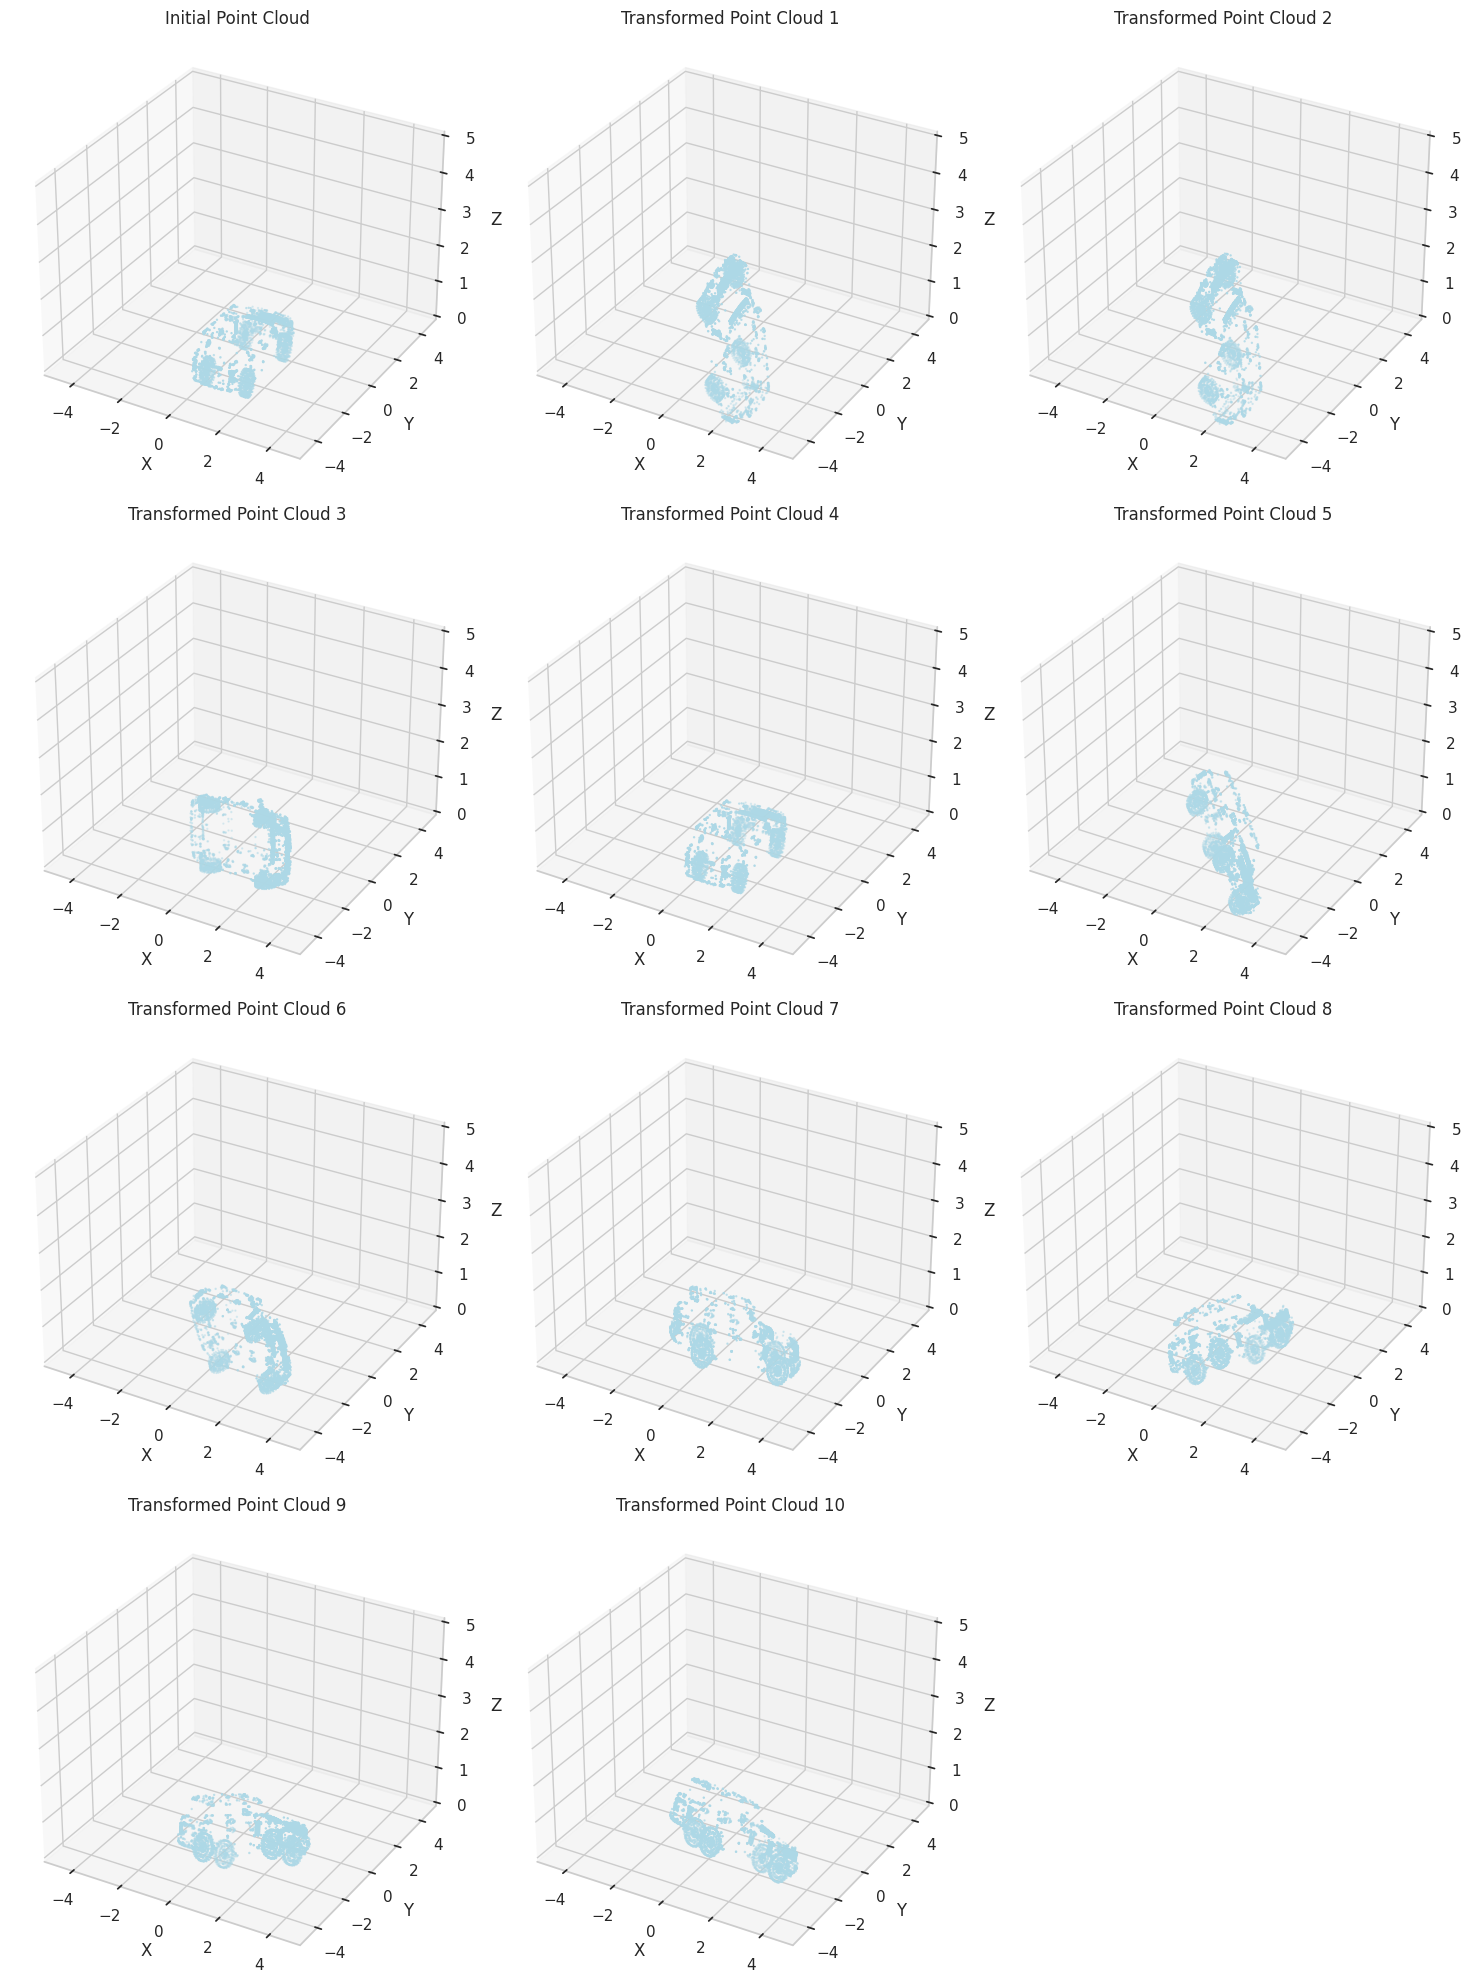

In [4]:
titles = ["Initial Point Cloud"] + [f"Transformed Point Cloud {i}" for i in range(1, 10 + 1)]
display_point_clouds([initial_pc] + point_cloud_dataset[:10], titles)

In [5]:
# Convert point clouds to torch tensors
point_cloud_dataset = torch.tensor(point_cloud_dataset, dtype=torch.float32)
point_cloud_dataset.shape

/tmp/ipykernel_19757/3499426091.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  point_cloud_dataset = torch.tensor(point_cloud_dataset, dtype=torch.float32)


torch.Size([100, 4294, 3])

In [8]:
# Define the model
point_features = 3
num_heads = 3
latent_dim = 64
model = MHA_AutoEncoder(point_features, num_heads, latent_dim)

# Define using the mean squared error loss
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move the model to the chosen device
model = model.to(device)

Using device: cuda


In [9]:
num_epochs = 100
batch_size = 10  # Smaller batch size
num_batches = len(point_cloud_dataset) // batch_size

for epoch in range(num_epochs):
    for i in range(num_batches):
        batch_data = point_cloud_dataset[i * batch_size:(i + 1) * batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()
        print("batch loss:", loss.item())

   



After attention: torch.Size([10, 4294, 3])
After attention: torch.Size([10, 4294, 3])
Encoded shape: torch.Size([10, 4294, 3])
Decoded shape: torch.Size([10, 4294, 3])
batch loss: 1.2330386638641357
After attention: torch.Size([10, 4294, 3])
After attention: torch.Size([10, 4294, 3])
Encoded shape: torch.Size([10, 4294, 3])
Decoded shape: torch.Size([10, 4294, 3])


KeyboardInterrupt: 